In [27]:
"""
General utils for training, evaluation and data loading
"""
import os
import torch
import pickle
import numpy as np
import torchvision.transforms as transforms

from PIL import Image

from torch.utils.data import BatchSampler
from torch.utils.data import Dataset, DataLoader

# General
BASE_DIR = ''
N_ATTRIBUTES = 312
N_CLASSES = 200

# Training
UPWEIGHT_RATIO = 9.0
MIN_LR = 0.0001
LR_DECAY_SIZE = 0.1

class CUBDataset(Dataset):
    """
    Returns a compatible Torch Dataset object customized for the CUB dataset
    """

    def __init__(self, pkl_file_paths, use_attr, no_img, uncertain_label, image_dir, n_class_attr, transform=None):
        """
        Arguments:
        pkl_file_paths: list of full path to all the pkl data
        use_attr: whether to load the attributes (e.g. False for simple finetune)
        no_img: whether to load the images (e.g. False for A -> Y model)
        uncertain_label: if True, use 'uncertain_attribute_label' field (i.e. label weighted by uncertainty score, e.g. 1 & 3(probably) -> 0.75)
        image_dir: default = 'images'. Will be append to the parent dir
        n_class_attr: number of classes to predict for each attribute. If 3, then make a separate class for not visible
        transform: whether to apply any special transformation. Default = None, i.e. use standard ImageNet preprocessing
        """
        self.data = []
        self.is_train = any(["train" in path for path in pkl_file_paths])
        if not self.is_train:
            assert any([("test" in path) or ("val" in path) for path in pkl_file_paths])
        for file_path in pkl_file_paths:
            self.data.extend(pickle.load(open(file_path, 'rb')))
        self.transform = transform
        self.use_attr = use_attr
        self.no_img = no_img
        self.uncertain_label = uncertain_label
        self.image_dir = image_dir
        self.n_class_attr = n_class_attr

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data = self.data[idx]
        img_path = img_data['img_path']
        
        # Trim unnecessary paths
        try:
            idx = img_path.split('/').index('CUB_200_2011')
            if self.image_dir != 'images':
                img_path = '/'.join([self.image_dir] + img_path.split('/')[idx+1:])
                img_path = img_path.replace('images/', '')
            else:
                img_path = '/'.join(img_path.split('/')[idx:])
            img = Image.open(img_path).convert('RGB')
        except:
            #img_path_split = img_path.split('/')
            #split = 'train' if self.is_train else 'test'
            #img_path = '/'.join(img_path_split[:2] + [split] + img_path_split[2:])
            
            img = Image.open(img_path).convert('RGB')

        class_label = img_data['class_label']
        if self.transform:
            img = self.transform(img)

        if self.use_attr:
            if self.uncertain_label:
                attr_label = img_data['uncertain_attribute_label']
            else:
                attr_label = img_data['attribute_label']
            if self.no_img:
                if self.n_class_attr == 3:
                    one_hot_attr_label = np.zeros((N_ATTRIBUTES, self.n_class_attr))
                    one_hot_attr_label[np.arange(N_ATTRIBUTES), attr_label] = 1
                    return one_hot_attr_label, class_label
                else:
                    return attr_label, class_label
            else:
                return img, class_label, attr_label
        else:
            return img, class_label


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices)

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):  # Note: for single attribute dataset
        return dataset.data[idx]['attribute_label'][0]

    def __iter__(self):
        idx = (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))
        return idx

    def __len__(self):
        return self.num_samples

def load_data(pkl_paths, use_attr, no_img, batch_size, uncertain_label=False, n_class_attr=2, image_dir='images', resampling=False, resol=299):
    """
    Note: Inception needs (299,299,3) images with inputs scaled between -1 and 1
    Loads data with transformations applied, and upsample the minority class if there is class imbalance and weighted loss is not used
    NOTE: resampling is customized for first attribute only, so change sampler.py if necessary
    """
    resized_resol = int(resol * 256/224)
    is_training = False #any(['train.pkl' in f for f in pkl_paths])
    if is_training:
        transform = transforms.Compose([
            #transforms.Resize((resized_resol, resized_resol)),
            #transforms.RandomSizedCrop(resol),
            transforms.ColorJitter(brightness=32/255, saturation=(0.5, 1.5)),
            transforms.RandomResizedCrop(resol),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(), #implicitly divides by 255
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
            #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
            ])
    else:
        transform = transforms.Compose([
            #transforms.Resize((resized_resol, resized_resol)),
            transforms.CenterCrop(resol),
            transforms.ToTensor() #implicitly divides by 255
            #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
            #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
            ])

    dataset = CUBDataset(pkl_paths, use_attr, no_img, uncertain_label, image_dir, n_class_attr, transform)
    if is_training:
        drop_last = True
        shuffle = True
    else:
        drop_last = False
        shuffle = False
    if resampling:
        sampler = BatchSampler(ImbalancedDatasetSampler(dataset), batch_size=batch_size, drop_last=drop_last)
        loader = DataLoader(dataset, batch_sampler=sampler)
    else:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return loader

def find_class_imbalance(pkl_file, multiple_attr=False, attr_idx=-1):
    """
    Calculate class imbalance ratio for binary attribute labels stored in pkl_file
    If attr_idx >= 0, then only return ratio for the corresponding attribute id
    If multiple_attr is True, then return imbalance ratio separately for each attribute. Else, calculate the overall imbalance across all attributes
    """
    imbalance_ratio = []
    data = pickle.load(open(os.path.join(BASE_DIR, pkl_file), 'rb'))
    n = len(data)
    n_attr = len(data[0]['attribute_label'])
    if attr_idx >= 0:
        n_attr = 1
    if multiple_attr:
        n_ones = [0] * n_attr
        total = [n] * n_attr
    else:
        n_ones = [0]
        total = [n * n_attr]
    for d in data:
        labels = d['attribute_label']
        if multiple_attr:
            for i in range(n_attr):
                n_ones[i] += labels[i]
        else:
            if attr_idx >= 0:
                n_ones[0] += labels[attr_idx]
            else:
                n_ones[0] += sum(labels)
    for j in range(len(n_ones)):
        imbalance_ratio.append(total[j]/n_ones[j] - 1)
    if not multiple_attr: #e.g. [9.0] --> [9.0] * 312
        imbalance_ratio *= n_attr
    return imbalance_ratio

In [18]:
!pip install gdown

In [19]:
!gdown 1DUkovCVCUqYScle624llHyeUuC7t0SaN #images
!gdown 1oRBQ7WY_9-qfWkxNC7ZGBW27wecfEy6f #train.pkl
!gdown 1EsYvhX6aRDELjoKpcRo3fuLo-aKF6DI9 #test.pkl
!gdown 1ir5HukW2XO25GWqx3jV-gKZWWi6Zg_rw #val.pkl
!gdown 1PFu7qcTS2tURPKCKYGJbosXrhFO3U1yu #model.pth

Downloading...
From (uriginal): https://drive.google.com/uc?id=1DUkovCVCUqYScle624llHyeUuC7t0SaN
From (redirected): https://drive.google.com/uc?id=1DUkovCVCUqYScle624llHyeUuC7t0SaN&confirm=t&uuid=20f8176c-adc0-4bf9-90fa-c8c6d8f01959
To: /kaggle/working/images.zip
100%|███████████████████████████████████████| 1.13G/1.13G [00:05<00:00, 199MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oRBQ7WY_9-qfWkxNC7ZGBW27wecfEy6f
To: /kaggle/working/kaggle_train.pkl
100%|████████████████████████████████████████| 497k/497k [00:00<00:00, 82.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EsYvhX6aRDELjoKpcRo3fuLo-aKF6DI9
To: /kaggle/working/kaggle_test.pkl
100%|████████████████████████████████████████| 601k/601k [00:00<00:00, 85.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ir5HukW2XO25GWqx3jV-gKZWWi6Zg_rw
To: /kaggle/working/kaggle_val.pkl
100%|████████████████████████████████████████| 124k/124k [00:00<00:00, 56.0MB/s]
Downloading...
From (uriginal): https://drive.

In [20]:
import zipfile

with zipfile.ZipFile('./images.zip',"r") as z:
    z.extractall()

Dataset loader from bottleneck concept script

In [21]:


train_data_path="/kaggle/working/kaggle_train.pkl"
val_data_path="/kaggle/working/kaggle_val.pkl"

train_loader = load_data([train_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)
val_loader = load_data([val_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)

In [22]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet18()
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('resnet18_trained.pth', map_location=device))

<All keys matched successfully>

In [35]:
import torch
from torch.autograd import Variable

def compute_saliency_maps(images, labels, model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Convert the images and labels to variables
    images = Variable(images, requires_grad=True)
    labels = Variable(labels)

    # Forward pass
    output = model(images)
    loss = torch.nn.functional.cross_entropy(output, labels)

    # Backward pass
    loss.backward()

    # Get the gradients of the input with respect to the loss
    gradients = images.grad.data

    # Absolute value of the gradients
    gradients = torch.abs(gradients)

    # Max of the gradients across the channels
    gradients, _ = torch.max(gradients, dim=1)

    # Normalize the gradients
    gradients = torch.div(gradients, torch.max(gradients))

    return gradients, output, labels

In [28]:
import matplotlib.pyplot as plt
import numpy 
import cv2

#load all  images from a test set
test_data_path = "/kaggle/working/kaggle_test.pkl"
test_loader = load_data([test_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)

img_list=[]
labels_list=[]
saliency_maps_list=[]

for images, labels in test_loader: #loading the whole dataset 

    img_list.append(images)
    labels_list.append(labels)
    

images_all= torch.cat(img_list)
labels_all=torch.cat(labels_list)


In [ ]:
!pip install grad-cam

Images to use: 

2339 - not explaining anything
1269 - good example, predicted right
4961 - good prediction, poor saliency map
148

In [67]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image



2339
Label: 82, prediction: 42 with probability 99.84898376464844%


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


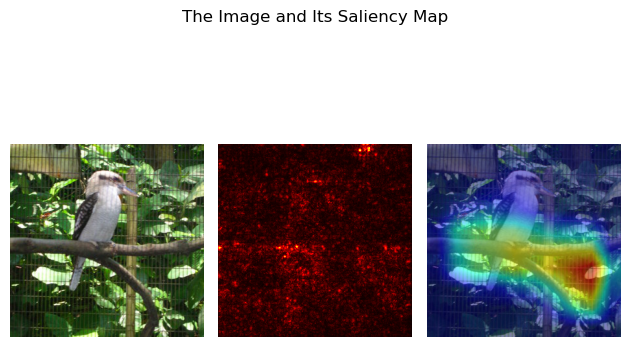

1269
Label: 46, prediction: 46 with probability 56.490211486816406%


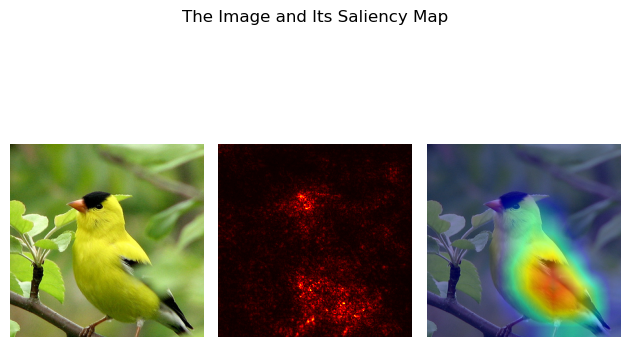

4961
Label: 171, prediction: 171 with probability 58.991390228271484%


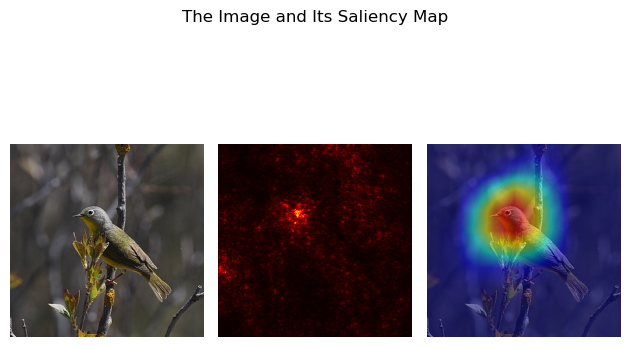

148
Label: 6, prediction: 6 with probability 13.59521484375%


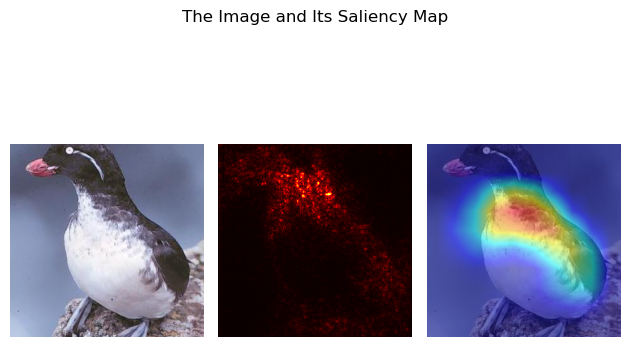

In [70]:
import random


#img_idx = random.sample(range(0, images_all.shape[0]), 20) #to see the random images
img_idx=[2339,1269,4961,148]
img_batch=images_all[img_idx,:,:,:]
labels_batch=labels_all[img_idx]


saliency_maps, output, labels =compute_saliency_maps(img_batch, labels_batch, model)
saliency_maps=saliency_maps.numpy().transpose(1, 2, 0)

target_layers = [model.layer4]
cam =GradCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = None
grayscale_cam = cam(input_tensor=img_batch, targets=targets, aug_smooth=True, eigen_smooth=True)


for i in range(len(img_idx)):
    
    
    print(img_idx[i])
    sal_map =  saliency_maps[:,:,i]
    
    percentage = torch.nn.functional.softmax(output[i]) * 100
    index = torch.argmax(output[i])
    #
    # Print the name along with score of the object identified by the model
    #
    
    print(f'Label: {labels[i]}, prediction: {index} with probability {percentage[index].item()}%')
    # Convert the saliency map to a heatmap and normalize it between 0 and 1
    heatmap = np.uint8(255 * saliency_maps[:,:, i]/np.max(saliency_maps[:,:, i]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Resize the heatmap to the size of the original image
    heatmap = cv2.resize(heatmap, (img_batch.size(-1), img_batch.size(-2)))
    
    grayscale_cam_img = grayscale_cam[i, :]
    visualization = show_cam_on_image(img_batch[i].squeeze().numpy().transpose((1, 2, 0)), grayscale_cam_img, use_rgb=True)


    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(img_batch[i].cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(sal_map, cmap='hot')
    ax[1].axis('off')
    ax[2].imshow(visualization, cmap='hot')
    ax[2].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()

# grad CAM 
Not really working, still need some 


Some metrics - still need a 